# Model \#1

In [1]:
print("hello world")
print("I'm comming to save you!")
print("Thank you so much,you really save my ass")

hello world
I'm comming to save you!
Thank you so much,you really save my ass


In [178]:
import pandas as pd
import numpy as np
import statsmodels.api as smd
from statsmodels.regression import linear_model
import requests
import json
import tushare as ts
import statsmodels.formula as smf
%matplotlib inline

In [3]:
%%time
# 读取模型文件，设置需要用的sheet叫final，去掉自动读取Header，因为你用了3行描述变量，所以我们要手动挑出真正需要的行(1)作为header
# so，dear betty，下次记得如果想用Python处理excel数据，请只设置一行作为Header,尽量用英文，这样我们读取数据时候会更方便
#betty提问：是不是如果有header，就写header=?,header是不是等于列级索引？
# 对，header就是列级索引，一般来说pandas都会自动识别，咱们这次因为有很多行作为header，所以需要手动处理
model_data=pd.read_excel('betty_data/模型1-2018.2.2-2046.xlsx',sheet_name='final',header=None)
# 把第[1]行的数据设置为header[列级索引]
model_data.columns=model_data.iloc[1]
# 扔掉不再用的前3行，只保留数据
model_data=model_data.drop([0,1,2])

CPU times: user 44.5 s, sys: 392 ms, total: 44.9 s
Wall time: 44.9 s


In [4]:
#哈哈，我错了，我应该和你说，有英文的header，就是第一行~这个是数据库下下来就这样，有3行数据，中文名字、英文名字和单位，所以如果想要简单处理
#应该把2、3行删掉是吧
#而且，为了不会混淆，是不是我模型的变量名称得和数据库里的一样，这个我得检查一下，因为我的变量英文名称（word里的那些命名）都是自己起的，还是
#统一起来比较好！对不对！
# 对！尽量都统一！
#然后就是好尴尬，竟然忘记评论是怎么设置了，只能全部#####~~囧
# 哈哈哈哈，这个叫注释，跟我念，Zhu Shi，用ctrl+/

In [5]:
model_data.columns
#这里的意思可以对照word里的模型变量名称看一哈~
# 嗯嗯，我一直在这样对照

Index(['ReportID', '年-券商', '年-证券代码', 'Rptdt', 'Year', 'Stkcd', 'InstitutionID',
       'Brokern', 'RelativeAccuracy', 'SecSize', 'ActiveAnalyst',
       'StarAnalyst', 'ReportNumber', 'CompanySize', 'Big4', 'AnaAttention',
       'ReportAttention', 'CompanyOpacity', 'Duration', 'LOSS', 'ROE', 'EPS',
       'Growth'],
      dtype='object', name=1)

In [6]:
# 看下到底都有什么证券
broker_name_groups=model_data.groupby('Brokern')
# broker_name_groups.groups.keys()
all_brokers=list(broker_name_groups.groups.keys())
# 我们把这些证券公司的名字存进一个列表或者ndarray吧，以便于之后使用

In [7]:
# 我试着把他们的机构代码提取出来了，也是为了之后的数据整合使用
#艾玛，这一行好长，看不懂~
broker_code_dict=dict(map(lambda x:(x,list(set(broker_name_groups.get_group(x)[['InstitutionID']].values.flatten()))[0]), all_brokers))

In [8]:
# model_data.groupby('Year').groups.keys()
# 运行之后你会看到年份有的是数值，有的是文字，所以我们需要处理一下

In [9]:
# 把所有年份变成str类型，当然你也可以用int()
model_data['Year']=model_data['Year'].apply(lambda x:str(x))

In [10]:
# 再看一下，没有重复的就对了
list(sorted(list(model_data.groupby('Year').groups.keys())))

['2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

- 把这块备好货之后我们就要想办法把那个公司排名的数据整合进这个表里了，但是我们还不能着急，因为那个表里你没有用证券代码来作为索引，所以可能增加了些难度，不过不是问题，我们也会搞定的，下面我们先把那个表的数据读取一下，看看都是什么

In [11]:
year_ranking={}
for i in range(2002,2017):
#     这里使用try except捕获异常，因为你的年份不是连续的，但是我又不想手动输入都有哪些年，所以我捕获掉没有那一年的异常
# 就是说在读取那一年的时候，会读不到数据，但是程序不会报错，只会pass掉那一年，继续读取
#  Betty：这个高端了，可以自动跳过
    try:
        ranking_df=pd.read_excel('betty_data/company_ranking.xlsx',sheet_name=str(i))
#         你的数据里有空行啥的，我需要drop一下空值
        ranking_df=ranking_df.dropna()
#       因为你说只想要前20的，但是数据有的是多余20的，所以我在读取的时候就只截取了前20了
        if ranking_df.shape[0]>20:
            ranking_df=ranking_df[:20]
#       把每一年的前20的优秀同志的名字装入dict，准备烹饪
        year_ranking[str(i)]=ranking_df[ranking_df.columns[1]].values.flatten()
    except:
        pass

In [12]:
ranking_matrix=pd.DataFrame(year_ranking)

- 拿到这个big table之后，我们要想办法把它和之前读取进来的变量表相结合，这就需要编写一个算法，来做字符串匹配，确保简写的证券公司和全称的证券公司在该年能对上号，如果能的话，我们置1，否则，0。
- Here we go, 我们试试怎么搞

In [13]:
%%time
# 所以我们写个小算法，做出一个序列，用于存储有数据的年份的公司是否在前20，如果没有年份就装入np.nan
ranking_series=[]
# 遍历model_data的每一行
for k,v in model_data[['Year','Brokern']].iterrows():
    if v['Year'] in ranking_matrix.columns:
#         查看该年的序列里有没有这一行的名字（因为我看模型数据的名字没有缩写，只有排名表的名字有缩写，所以用排名 in Brokern）
        in_specific_rank=np.sum(ranking_matrix[v['Year']].apply(lambda x: x in v['Brokern']))
        ranking_series.append(int(np.sign(in_specific_rank)))
    else:
        ranking_series.append(np.nan)

CPU times: user 26.6 s, sys: 4 ms, total: 26.6 s
Wall time: 26.6 s


In [14]:
model_data['SecSize']=ranking_series

In [15]:
# 我们先去掉Duration列
model_data=model_data.drop('Duration',axis=1)

In [16]:
# 然后四大的那一列处理的不好，有0,n,y,nan，所以我需要重新处理，让它只包含0,1,nan
value_dict={0:np.nan,'N':0,'Y':1,np.nan:np.nan}
model_data[['Big4']]=model_data['Big4'].apply(lambda x: value_dict[x])

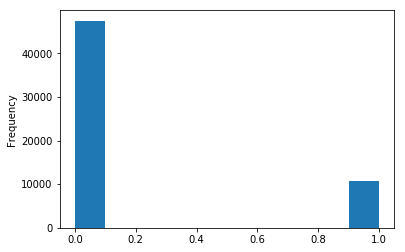

In [17]:
model_data['Big4'].plot(kind='hist')

In [18]:
# 处理一下companyopacity，把它变成categorical能用的类型.apply(lambda x: value_dict[x])
opacity_dict={0:np.nan,'A':1,'B':2,'C':3,'D':4,np.nan:np.nan}
model_data[['CompanyOpacity']]=model_data['CompanyOpacity'].apply(lambda x:opacity_dict[x])

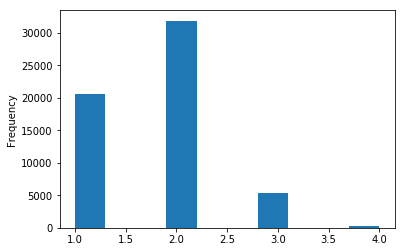

In [19]:
model_data['CompanyOpacity'].plot(kind='hist')

In [20]:
%%time
# 下面，我们来重新计算roe，需要读入资产负债表，咱们一点一点来
asset=pd.read_excel('betty_data/asset_liability_1990_2017.xlsx',sheet_name='年末数据')

CPU times: user 1min 8s, sys: 2.14 s, total: 1min 10s
Wall time: 1min 10s


In [21]:
# 把第行列定义为表头
asset.columns=asset.iloc[0]

In [22]:
# 然后去掉不用的表头
asset=asset.drop([0,1])

In [23]:
# 对表头做一下处理，因为里面有的是空的，有的带撇号，所以都处理一下
column_list=list(asset.columns)
column_list[2]="year"
column_list[3]="year_code"
column_list=list(map(lambda x:x.replace("'","").strip(),column_list))
asset.columns=column_list

In [24]:
# 把year换成str类型
asset['year']=asset['year'].map(lambda x:str(int(x)))

In [25]:
# 我们只留下报表类型为A的数据，要不然的话，相减出来的东西有很多是同一年，A,B报表类型的行相减的结果，不是我们要的
asset=asset[asset['报表类型']=='A']

In [26]:
# groupby一下
asset_groups=asset.groupby('证券代码')
asset_groups_keys=list(asset_groups.groups.keys())

In [27]:
# 先把roe这列全设置为nan，然后按照分组填充
asset['roe']=np.nan

In [28]:
%%time
# 按照组自动计算roe，并填充到相应的证券
test_group=None
for key in asset_groups_keys:
    test_group=asset[asset['证券代码']==key]
    mean_liability=(test_group['所有者权益合计']+test_group['所有者权益合计'].shift(-1))/2
    asset['roe'][asset['证券代码']==key] = test_group['净利润']/(mean_liability)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 52.1 s, sys: 416 ms, total: 52.5 s
Wall time: 52.5 s


In [29]:
%%time
# 同样，我们读取利润表
profit=pd.read_excel('betty_data/profit_1990_2017.xlsx',sheet_name='每年数据（刨除季度）')

CPU times: user 1min 25s, sys: 1.53 s, total: 1min 27s
Wall time: 1min 27s


In [30]:
# 把表头按照资产负债表的方式做处理
profit.columns=profit.iloc[0]
column_list=list(profit.columns)
column_list[1]="year"
column_list[2]="year_code"
column_list=list(map(lambda x:str(x).replace("'","").strip(),column_list))
profit.columns=column_list

In [31]:
# 去掉0和1行
profit=profit.drop([0,1],axis=0)

In [32]:
# 把year换成str类型
profit['year']=profit['year'].map(lambda x:str(int(x)))

In [33]:
profit=profit[profit['报表类型']=='A']

In [34]:
# groupby一下
profit_groups=profit.groupby('证券代码')
profit_groups_keys=list(profit_groups.groups.keys())

In [35]:
# 先把growth设置成nan
profit['growth']=np.nan

In [36]:
%%time
# 按照组自动计算growth，并填充到相应的证券
for key in profit_groups_keys:
    test_group=profit[profit['证券代码']==key]
#     去掉营业总收入为0的行
    test_group=test_group[test_group['营业总收入']!=0]
#     相减，求growth
    profit_value=test_group['营业总收入']-test_group['营业总收入'].shift(-1)
    profit['growth'][profit['证券代码']==key] = profit_value/test_group['营业总收入'].shift(-1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 4min 58s, sys: 660 ms, total: 4min 58s
Wall time: 4min 58s


In [37]:
# 把我们处理好的数据用year_code建立索引
profit.index=profit['year_code']

In [38]:
asset.index=asset['year_code']

In [39]:
growth=profit['growth'].dropna()

In [40]:
roe=asset['roe'].dropna()

In [41]:
growth.count()

34596

In [42]:
roe.count()

34695

In [43]:
ready_data=model_data.join(roe,on='年-证券代码').join(growth,on='年-证券代码')

- 2018-02-10 01:25 AM
- 加入SecLoc,Underwriter,Transparency, ReportAttention, AnaAttention变量

- SecLoc不用了，下面的代码全部做注释处理，Betty想要学习的话可以看看，还算有价值的一个小case

- SecLoc又用了 -.-

In [44]:
# 抓取券商地区数据
brokers_response=requests.post('http://jg.sac.net.cn/pages/publicity/resource!search.action',data={
    'filter_EQS_O#otc_id':'01',
    'filter_EQS_O#sac_id':'',
    'filter_LIKES_aoi_name':'',
    'sqlkey':'publicity',
    'sqlval':'ORG_BY_TYPE_INFO'
})
broker_location_dict=json.loads(brokers_response.text)


# 将券商地区数据存储在文件中
broker_location_file=open('betty_data/broker_location.json','w+')
broker_location_file.write(json.dumps(broker_location_dict))



18829

In [45]:

# 抓取地区字典
location_response=requests.post('http://jg.sac.net.cn/pages/publicity/resource!search.action',data={
    'sqlkey':'statusDimension',
    'sqlval':'SELECT_AREA_INFO'
})
location_dict=json.loads(location_response.text)
# 存储成文件
location_dict_file=open('betty_data/location_dict.json','w+')
location_dict_file.write(json.dumps(location_dict).strip())
# 制作成表示形态更好的字典
location_dict=dict(map(lambda x:(x['SAC_ID'],x['SAC_NAME']),location_dict))

In [46]:
# 制作一个地区dataframe
broker_location_df=pd.DataFrame(list(map(lambda x:{'Brokern':x['AOI_NAME'],'broker_location':location_dict[x['SAC_ID']]},broker_location_dict)))
broker_location_df.index=broker_location_df['Brokern']

In [47]:
# 去掉括号里的各种（不含<某市>）
# 按照省级地理位置来考虑是否属于一个地区
broker_location_df['broker_location']=broker_location_df['broker_location'].apply(lambda x:x.split('（')[0])
# 读取上市公司所在地信息
IPO_basic=pd.read_excel('betty_data/IPO_Cobasic.xls')
# 去掉不需要的head
IPO_basic=IPO_basic[2:]
# 把stockcode作为index
IPO_basic.index=IPO_basic['Stkcd']
# 去掉location_dict里的括号内容
province_list=list(map(lambda x:x.split('（')[0],location_dict.values()))

In [48]:
def match_province(place):
    filtered_list=list(filter(lambda y:y in place,province_list))
    filtered_list_length=len(filtered_list)
    if filtered_list_length>1:
        return filtered_list[1]
    elif filtered_list_length==1:
        return filtered_list[0]
    else:
        place

In [49]:
# 识别出上市公司所在省份
IPO_basic['Province']=IPO_basic['Regplc'].apply(lambda x: match_province(x))
# 连接两个表，然后对比上市公司和券商是否在一个地区，如果是的话就1，否则0
ready_data['SecLoct']=ready_data.join(broker_location_df['broker_location'],on='Brokern').join(IPO_basic['Province'],on='Stkcd').apply(lambda x: int(x['broker_location']==x['Province']),axis=1)

In [50]:
# 2018-02-11 01:01 AM
# SecLoct搞定
#厉害了，真是科技改变生活啊
# 那必须~

---

In [51]:
import editdistance

In [52]:
# 处理Underwriter
# 我看你的AF_Co里承销商和推荐人的公司名称不是特别规范，比如 是否存在(深圳经济特区证券公司 == 深圳特区证券公司)的关系？
# 如果存在的话，我可能需要用文本相似度计算是否属于同一个公司，因为不好直接用字符串匹配来识别
# 我可能用edit distance计算文本相似度，取小于2 的编辑距离作为判断是否是同一家公司的标准
# OK，我们先读入数据，然后处理一下
IPO=pd.read_excel('betty_data/AF_Co.xls')

In [53]:
IPO.columns

Index(['Stkcd', 'Stknmec', 'Updt', 'Conme', 'Conmee', 'IndClaCd', 'Indus',
       'Indnme', 'Listdt', 'Udwnm', 'Sponsor', 'Http'],
      dtype='object')

In [54]:
# 设置索引
IPO.index=IPO['Stkcd']

In [55]:
IPO=IPO[2:]

In [56]:
# 去掉这两个列里有空值的行
IPO=IPO.dropna(subset=['Udwnm','Sponsor'])

In [57]:
# 计算两个公司的edit_distance
IPO['edit_distance']=IPO.apply(lambda x: min(map(lambda y: editdistance.eval(str(x['Udwnm']),y),str(x['Sponsor']).split(','))),axis=1)

In [58]:
# 如果edit_distance<2，就算是一个公司
IPO['underwriter']=IPO.apply(lambda x: 1 if x['edit_distance'] < 2 else 0,axis=1)

In [59]:
# 把表格连起来
ready_data=ready_data.join(IPO['underwriter'],on='Stkcd')

In [60]:
# Underwriter这个搞定了
# 2018-02-24 16:53 PM 加入行业分类标识
ready_data=ready_data.join(IPO['Indnme'],on='Stkcd')

In [61]:
ready_data.columns

Index(['ReportID', '年-券商', '年-证券代码', 'Rptdt', 'Year', 'Stkcd', 'InstitutionID',
       'Brokern', 'RelativeAccuracy', 'SecSize', 'ActiveAnalyst',
       'StarAnalyst', 'ReportNumber', 'CompanySize', 'Big4', 'AnaAttention',
       'ReportAttention', 'CompanyOpacity', 'LOSS', 'ROE', 'EPS', 'Growth',
       'roe', 'growth', 'SecLoct', 'underwriter', 'Indnme'],
      dtype='object')

In [62]:
# 去掉金融业的公司
ready_data['Indnme'].unique()

array(['货币金融服务', '房地产业', '生态保护和环境治理业', nan, '铁路、船舶、航空航天和其它运输设备制造业',
       '土木工程建筑业', '非金属矿物制品业', '计算机、通信和其他电子设备制造业', '建筑装饰和其他建筑业',
       '酒、饮料和精制茶制造业', '水上运输业', '批发业', '零售业', '电力、热力生产和供应业', '汽车制造业',
       '住宿业', '商务服务业', '金属制品业', '农副食品加工业', '电气机械及器材制造业', '石油加工、炼焦及核燃料加工业',
       '有色金属冶炼及压延加工业', '公共设施管理业', '道路运输业', '航空运输业', '卫生', '医药制造业',
       '化学原料及化学制品制造业', '广播、电视、电影和影视录音制作业', '专用设备制造业', '纺织业', '通用设备制造业',
       '天然原油开采业', '燃气生产和供应业', '综合', '租赁业', '其他金融业', '化学纤维制造业', '有色金属矿采选业',
       '造纸及纸制品业', '互联网和相关服务', '新闻和出版业', '专用化学产品制造业', '教育', '通信设备制造业',
       '水的生产和供应业', '煤炭开采和洗选业', '软件和信息技术服务业', '远洋运输业', '铁路运输业', '资本市场服务',
       '化学肥料制造业', '其他制造业', '橡胶和塑料制品业', '林业', '有机化学产品制造业', '保险业', '房屋建筑业',
       '黑色金属矿采选业', '家具制造业', '文化艺术业', '黑色金属冶炼及压延加工业', '专业技术服务业',
       '农、林、牧、渔服务业', '食品制造业', '餐饮业', '其他土木工程建筑业', '畜牧业', '石油制品业', '渔业',
       '印刷和记录媒介复制业', '废弃资源综合利用业', '合成纤维制造业', '电信、广播电视和卫星传输服务', '原油加工业',
       '木材加工及木、竹、藤、棕、草制品业', '石油和天然气开采业', '农业'], dtype=object)

In [63]:
# 去掉这些行业的
removed_industry=['货币金融服务','其他金融业','资本市场服务','保险业','租赁业']
ready_data=ready_data[ready_data.apply(lambda x: x.Indnme not in removed_industry,axis=1)]

In [64]:
ready_data.index=ready_data['ReportID']

In [65]:
# 去St的公司
st_stocks=pd.read_csv('betty_data/st_stock_new1.csv')

In [66]:
st_stocks['Stkcd']=st_stocks['Stkcd'].apply(lambda x: x.split('.')[0])

In [67]:
st_stocks.index=st_stocks['Stkcd']

In [68]:
def test_st(code,year):
    is_st=st_stocks[st_stocks['Stkcd']==code][year]
    if not is_st.empty:
        return is_st.values[0]
    else:
        return np.nan

In [69]:
%%time
ready_data['is_st']=ready_data.apply(lambda x: test_st(x['Stkcd'],x['Year']),axis=1)

CPU times: user 1min 9s, sys: 416 ms, total: 1min 10s
Wall time: 1min 10s


In [70]:
ready_data=ready_data[ready_data['is_st']==0]

In [71]:
# 2018-02-28 21:26:49 
# 读取基金持股数据
brokerage=pd.read_excel('betty_data/AF_BrokerageProfile.xls')

In [72]:
brokerage.index=brokerage.InstitutionID

In [73]:
FundShareHolderDict={'N':0,'Y':1,np.nan:np.nan}
brokerage['FundShareholder']=brokerage.FundShareholder.apply(lambda x:FundShareHolderDict[x])

In [74]:
brokerage['InstitutionID']=brokerage['InstitutionID'].apply(lambda x:str(x))

In [75]:
brokerage['IYID']=brokerage.apply(lambda x:'%s_%s'%(x['InstitutionID'],x['Accper'].split('-')[0]),axis=1)

In [76]:
brokerage.index=brokerage.IYID

In [77]:
ready_data['IYID']=ready_data.apply(lambda x:'%s_%s'%(x['InstitutionID'],x['Year'].split('-')[0]),axis=1)

In [78]:
ready_data=ready_data.join(brokerage['FundShareholder'],on='IYID')

In [79]:
final_ready_data=ready_data.drop(['ReportID', '年-券商', '年-证券代码', 'Rptdt', 'Year', 'Stkcd', 'InstitutionID','Growth','ROE','Brokern','is_st', 'Indnme','IYID'],axis=1)

In [80]:
# ready_data=ready_data[ready_data.columns[8:]]
final_ready_data=final_ready_data.dropna()

In [81]:
final_ready_data.shape

(14969, 17)

In [82]:
# 对companySize取对数
final_ready_data[['CompanySize']]=np.log(np.array(list(map(lambda x:float(x),final_ready_data[['CompanySize']].values.flatten()))))

In [83]:
final_ready_data=final_ready_data.apply(lambda x:np.array(x,dtype=np.float64))

In [161]:
# 好激动！准备送进模型了！

In [162]:
# 2018-02-22 14:13
# 对numerical variable 进行缩尾处理

In [84]:
 final_ready_data[['SecSize','Big4','LOSS', 'underwriter']]

SecSize  Big4  LOSS  underwriter
ReportID                                  
9876097       1.0   1.0   0.0          1.0
9864677       0.0   1.0   0.0          1.0
9851497       0.0   1.0   0.0          1.0
9842599       1.0   1.0   0.0          1.0
9830951       1.0   1.0   0.0          1.0
9817537       1.0   1.0   0.0          1.0
9799773       1.0   1.0   0.0          1.0
9783383       1.0   1.0   0.0          1.0
9783349       1.0   1.0   0.0          1.0
9771153       1.0   1.0   0.0          1.0
9760553       0.0   1.0   0.0          1.0
9754659       0.0   1.0   0.0          1.0
9752851       1.0   1.0   0.0          1.0
9744775       1.0   1.0   0.0          1.0
9742903       1.0   1.0   0.0          1.0
9699243       1.0   1.0   0.0          1.0
9691551       1.0   1.0   0.0          1.0
9638949       1.0   1.0   0.0          1.0
9624559       1.0   1.0   0.0          1.0
9623103       1.0   1.0   0.0          1.0
9602979       0.0   1.0   0.0          1.0
9601961       0.0   1.0   0.0          1.0
9593779       1.0   1.0   0.0          1.0
9593183       1.0   1.0   0.0          1.0
9591879       0.0   1.0   0.0          1.0
9589405       0.0   1.0   0.0          1.0
9589185       0.0   1.0   0.0          1.0
9586211       1.0   1.0   0.0          1.0
9582527       1.0   1.0   0.0          1.0
9582407       1.0   1.0   0.0          1.0
...           ...   ...   ...          ...
9139533       1.0   0.0   0.0          1.0
9119941       1.0   0.0   0.0          1.0
9048469       0.0   0.0   0.0          1.0
8919843       1.0   0.0   0.0          1.0
8918539       1.0   0.0   0.0          1.0
8904959       0.0   0.0   0.0          1.0
8837645       1.0   0.0   0.0          1.0
8384939       1.0   0.0   0.0          1.0
8382561       1.0   0.0   0.0          1.0
8381653       1.0   0.0   0.0          1.0
8311219       0.0   0.0   0.0          1.0
8306905       1.0   0.0   0.0          1.0
8306113       1.0   0.0   0.0          1.0
8250767       1.0   0.0   0.0          1.0
8149835       1.0   0.0   0.0          1.0
8096267       1.0   0.0   0.0          1.0
8096099       1.0   0.0   0.0          1.0
7806217       0.0   0.0   0.0          1.0
7767503       1.0   0.0   0.0          1.0
7623231       0.0   0.0   0.0          1.0
7620815       1.0   0.0   0.0          1.0
7607927       0.0   0.0   0.0          1.0
7482947       1.0   0.0   0.0          1.0
10005844      0.0   0.0   1.0          1.0
9992908       1.0   0.0   1.0          1.0
10001109      1.0   0.0   1.0          1.0
9976790       1.0   0.0   1.0          1.0
9964086       0.0   0.0   1.0          1.0
9913823       1.0   0.0   1.0          1.0
9980057       0.0   0.0   1.0          1.0

[14969 rows x 4 columns]

In [85]:
final_ready_data[['ActiveAnalyst', 'StarAnalyst',
       'ReportNumber', 'CompanySize',  'AnaAttention',
       'ReportAttention', 'CompanyOpacity', 'EPS', 'roe', 'growth']].describe()

ActiveAnalyst   StarAnalyst  ReportNumber   CompanySize  AnaAttention  \
count   14969.000000  14969.000000  14969.000000  14969.000000  14969.000000   
mean       45.905137     15.024985   1128.976351     23.127971     21.444318   
std        21.560576     18.962882    798.293183      1.367751     12.906780   
min         2.000000      0.000000      4.000000     18.610792      1.000000   
25%        30.000000      0.000000    533.000000     22.225591     11.000000   
50%        43.000000      6.000000    868.000000     22.944915     19.000000   
75%        59.000000     21.000000   1597.000000     23.946419     30.000000   
max       107.000000     64.000000   3261.000000     27.138846     65.000000   

       ReportAttention  CompanyOpacity           EPS           roe  \
count     14969.000000    14969.000000  14969.000000  14969.000000   
mean         50.285657        1.713341      0.381070      0.121667   
std          37.588110        0.616935      0.631832      0.395824   
min           1.000000        1.000000     -2.220000     -9.061974   
25%          23.000000        1.000000      0.000000      0.037724   
50%          41.000000        2.000000      0.070000      0.105965   
75%          68.000000        2.000000      0.610000      0.206230   
max         219.000000        4.000000      4.530000      0.771434   

             growth  
count  14969.000000  
mean       0.462902  
std        4.615248  
min       -0.918341  
25%        0.028368  
50%        0.155767  
75%        0.327485  
max      363.068296

In [86]:
# 取所有连续变量的列表
numerical_variables=['RelativeAccuracy','ActiveAnalyst', 'StarAnalyst','ReportNumber', 'CompanySize',  'AnaAttention','ReportAttention', 'CompanyOpacity', 'EPS', 'roe', 'growth']
# 遍历他们
for nv in numerical_variables:
#     拿到1%和99%分位数
    lower=final_ready_data[nv].quantile(q=0.01)
    upper=final_ready_data[nv].quantile(q=0.99)
#     把分位数之外的数据截断到分位数
    final_ready_data[nv][final_ready_data[nv]<lower]=lower
    final_ready_data[nv][final_ready_data[nv]>upper]=upper

In [87]:
import matplotlib.pyplot as plt

In [88]:
final_ready_data.RelativeAccuracy.describe()

count    14969.000000
mean        -0.152151
std          1.127823
min         -7.066400
25%         -0.290000
50%          0.050000
75%          0.400000
max          1.000000
Name: RelativeAccuracy, dtype: float64

RelativeAccuracy       Axes(0.125,0.125;0.065678x0.755)
ActiveAnalyst       Axes(0.203814,0.125;0.065678x0.755)
StarAnalyst         Axes(0.282627,0.125;0.065678x0.755)
ReportNumber        Axes(0.361441,0.125;0.065678x0.755)
CompanySize         Axes(0.440254,0.125;0.065678x0.755)
AnaAttention        Axes(0.519068,0.125;0.065678x0.755)
ReportAttention     Axes(0.597881,0.125;0.065678x0.755)
EPS                 Axes(0.676695,0.125;0.065678x0.755)
roe                 Axes(0.755508,0.125;0.065678x0.755)
growth              Axes(0.834322,0.125;0.065678x0.755)
dtype: object

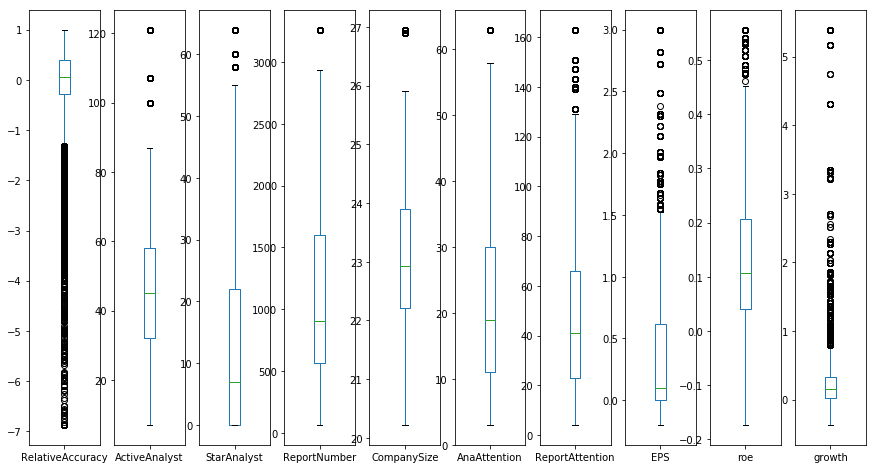

In [189]:
numerical_variables=['RelativeAccuracy','ActiveAnalyst', 'StarAnalyst','ReportNumber', 'CompanySize',  'AnaAttention','ReportAttention','EPS', 'roe', 'growth']
final_ready_data[numerical_variables].plot(subplots=True,kind='box',figsize=(15,8))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd18f8d8240>,
      dtype=object)

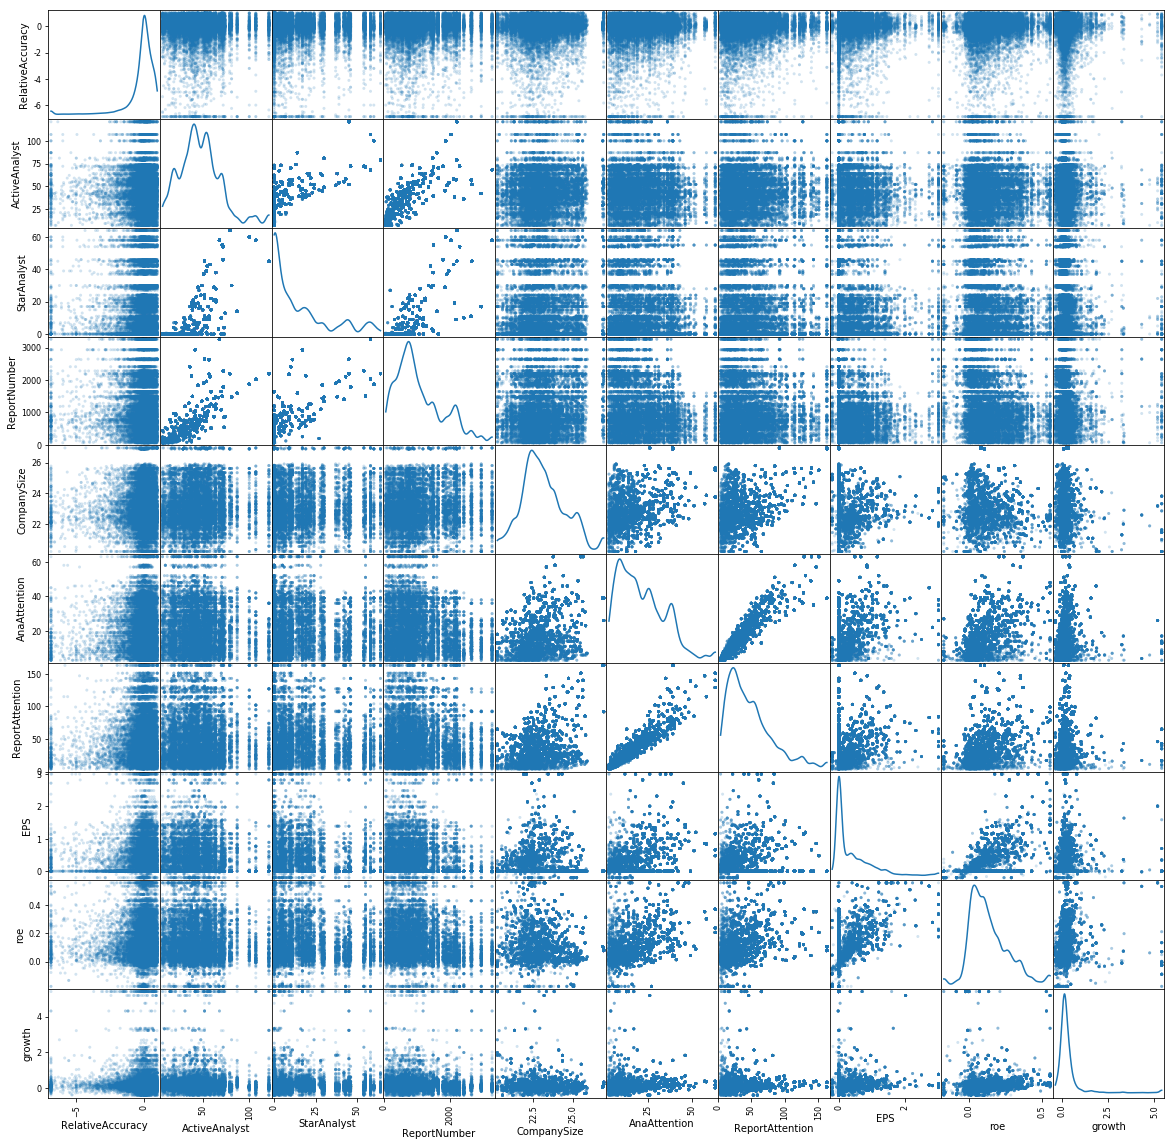

In [190]:
 from pandas.plotting import scatter_matrix
scatter_matrix(final_ready_data[numerical_variables], alpha=0.2, figsize=(20, 20), diagonal='kde')

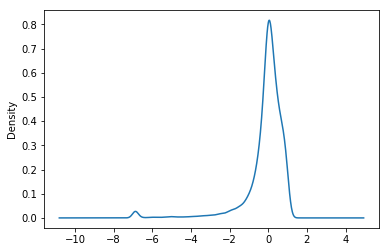

In [191]:
final_ready_data['RelativeAccuracy'].plot.density()

--- 

用一个不带正则化的线性回归模型试一下

In [202]:
'''
Y=final_ready_data['RelativeAccuracy'].values
X_all=final_ready_data[final_ready_data.columns[1:]]
X=final_ready_data[['ActiveAnalyst', 'StarAnalyst',
       'ReportNumber', 'CompanySize',  'AnaAttention',
       'ReportAttention', 'CompanyOpacity', 'EPS', 'roe', 'growth']].values
X_bin=final_ready_data[['SecSize','Big4','LOSS', 'SecLoct', 'underwriter']].values
X=np.array(X,dtype=np.float64)
X_all=np.array(X_all,dtype=np.float64)
Y=np.array(Y,dtype=np.float64)
'''

Y=final_ready_data['RelativeAccuracy'].values
X_all=final_ready_data[final_ready_data.columns[1:]]
X=final_ready_data[['ActiveAnalyst', 'StarAnalyst','ReportNumber', 'CompanySize',  'AnaAttention','ReportAttention','EPS', 'roe', 'growth']].values
# X_bin=final_ready_data[['SecSize','Big4','underwriter']].values
X=np.array(X,dtype=np.float64)
X=smd.add_constant(X)
X_all=np.array(X_all,dtype=np.float64)
X_all=smd.add_constant(X_all)
Y=np.array(Y,dtype=np.float64)

In [209]:
smf.api.ols('RelativeAccuracy~ActiveAnalyst+StarAnalyst+ReportNumber+CompanySize+CompanyOpacity+AnaAttention+ReportAttention+EPS+roe+growth+C(SecSize)+C(Big4)+C(LOSS)+C(underwriter)',data=final_ready_data).fit().summary()
# smf.api.ols('RelativeAccuracy~ActiveAnalyst+StarAnalyst+ReportNumber+CompanySize+AnaAttention+ReportAttention+EPS+roe+growth',data=final_ready_data).fit().summary()
# smf.api.ols('RelativeAccuracy~ReportNumber+AnaAttention+ReportAttention',data=final_ready_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeAccuracy   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     9.053
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.54e-20
Time:                        14:05:15   Log-Likelihood:                -28750.
No. Observations:               19123   AIC:                         5.753e+04
Df Residuals:                   19108   BIC:                         5.765e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4028      0.176     -2.294      0.022      -0.747      -0.059
C(SecSize)[T.1.0]         0.0079      0.020      0.388      0.698      -0.032       0.048
C(Big4)[T.1.0]            0.0045      0.023      0.195      0.845      -0.041       0.050
C(LOSS)[T.1.0]            0.0129      0.023      0.572      0.567      -0.031       0.057
C(underwriter)[T.1.0]    -0.0062      0.019     -0.328      0.743      -0.043       0.031
ActiveAnalyst            -0.0004      0.001     -0.653      0.513      -0.001       0.001
StarAnalyst              -0.0005      0.001     -0.678      0.498      -0.002       0.001
ReportNumber           4.959e-05   1.56e-05      3.172      0.002    1.89e-05    8.02e-05
CompanySize               0.0036      0.007      0.486      0.627      -0.011       0.018
CompanyOpacity            0.0069      0.014      0.482      0.629      -0.021       0.035
AnaAttention              0.0031      0.002      1.933      0.053   -4.27e-05       0.006
ReportAttention           0.0013      0.001      2.270      0.023       0.000       0.002
EPS                       0.0193      0.021      0.909      0.363      -0.022       0.061
roe                      -0.0421      0.079     -0.535      0.593      -0.196       0.112
growth                   -0.0154      0.012     -1.301      0.193      -0.039       0.008
==============================================================================
Omnibus:                    14459.161   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           268880.775
Skew:                          -3.570   Prob(JB):                         0.00
Kurtosis:                      19.926   Cond. No.                     3.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd18d6b08d0>,
      dtype=object)

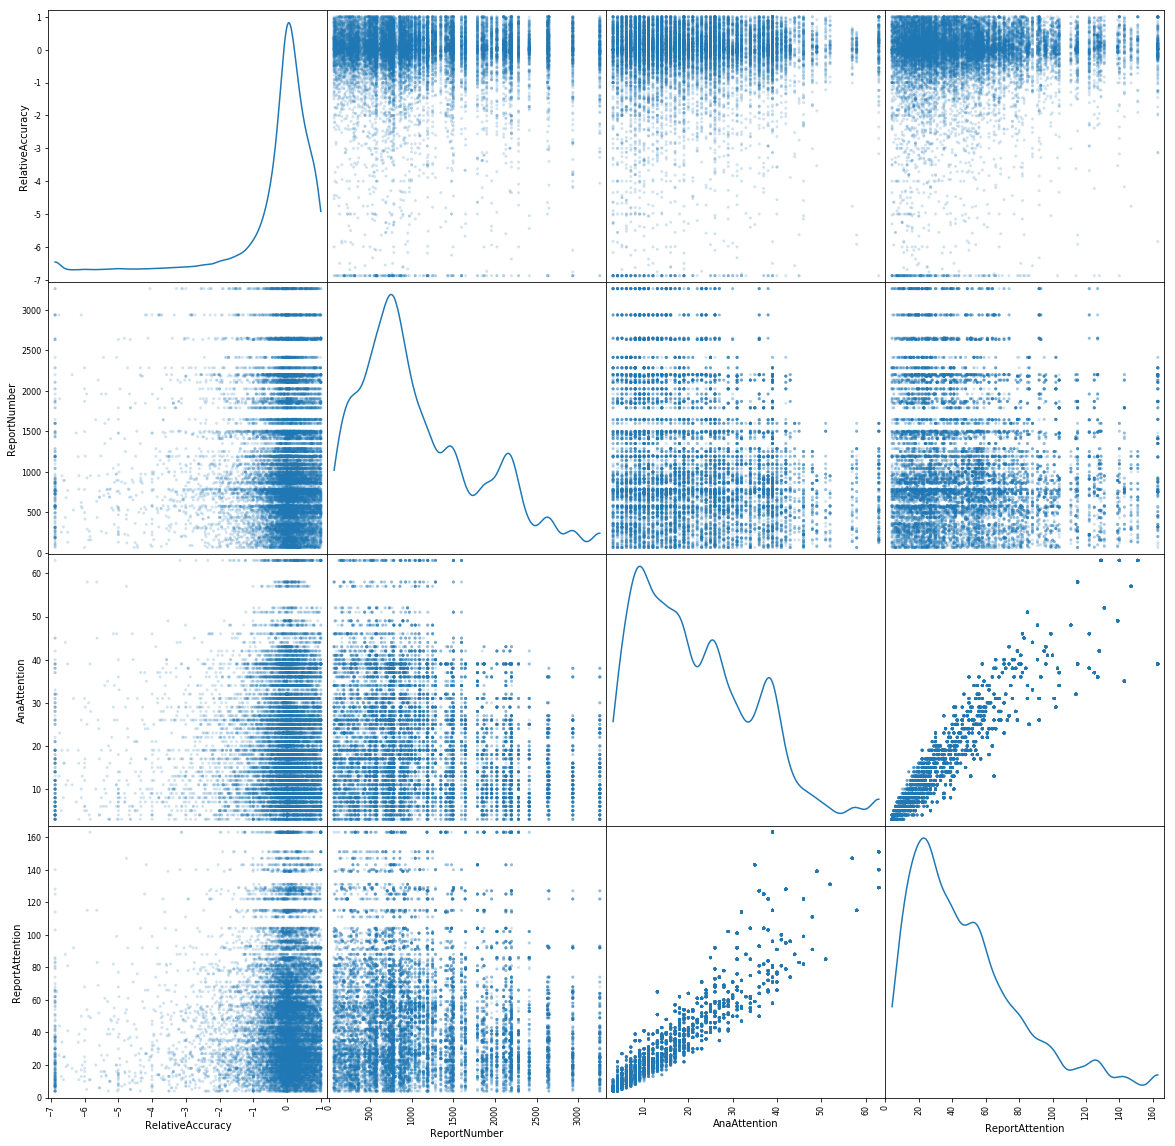

In [208]:
 from pandas.plotting import scatter_matrix
scatter_matrix(final_ready_data[['RelativeAccuracy','ReportNumber','AnaAttention','ReportAttention']], alpha=0.2, figsize=(20, 20), diagonal='kde')

In [204]:
linear_model.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     13.99
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           9.97e-23
Time:                        13:56:42   Log-Likelihood:                -28751.
No. Observations:               19123   AIC:                         5.752e+04
Df Residuals:                   19113   BIC:                         5.760e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3704      0.161     -2.306      0.021      -0.685      -0.056
x1            -0.0003      0.001     -0.513      0.608      -0.001       0.001
x2            -0.0005      0.001     -0.663      0.507      -0.002       0.001
x3           4.81e-05   1.52e-05      3.165      0.002    1.83e-05    7.79e-05
x4             0.0029      0.007      0.409      0.682      -0.011       0.017
x5             0.0032      0.002      2.097      0.036       0.000       0.006
x6             0.0012      0.001      2.237      0.025       0.000       0.002
x7             0.0258      0.018      1.429      0.153      -0.010       0.061
x8            -0.0453      0.078     -0.580      0.562      -0.198       0.108
x9            -0.0152      0.012     -1.283      0.200      -0.038       0.008
==============================================================================
Omnibus:                    14456.238   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           268648.011
Skew:                          -3.569   Prob(JB):                         0.00
Kurtosis:                      19.918   Cond. No.                     2.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [163]:
import statsmodels.formula.api as smf

In [219]:
model=smf.ols('RelativeAccuracy~CompanySize+AnaAttention+ReportAttention+EPS+roe',data=group_test).fit()

In [220]:
model.params

Intercept          2.397008
CompanySize       -0.124850
AnaAttention       0.007810
ReportAttention    0.002506
EPS               -0.072689
roe               -0.255000
dtype: float64

In [221]:
#依照下面这个结果看，结果不咋样，去掉loss，secloct，'ActiveAnalyst', 'StarAnalyst','ReportNumber'试试

In [222]:
model.summary()
# 我先睡一觉，起来之后解读一下这个矩阵

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeAccuracy   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8146
Date:                Sat, 24 Feb 2018   Prob (F-statistic):              0.539
Time:                        06:31:15   Log-Likelihood:                -4090.8
No. Observations:                1703   AIC:                             8194.
Df Residuals:                    1697   BIC:                             8226.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.3970      2.359      1.016      0.310      -2.230       7.024
CompanySize        -0.1248      0.105     -1.186      0.236      -0.331       0.082
AnaAttention        0.0078      0.011      0.706      0.480      -0.014       0.030
ReportAttention     0.0025      0.004      0.593      0.553      -0.006       0.011
EPS                -0.0727      0.116     -0.629      0.530      -0.299       0.154
roe                -0.2550      0.654     -0.390      0.697      -1.538       1.028
==============================================================================
Omnibus:                     4580.861   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         92506375.557
Skew:                         -31.274   Prob(JB):                         0.00
Kurtosis:                    1143.070   Cond. No.                     3.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
# 2018-02-11 01:07
# Model 1 暂时搞定，但是不显著，试试换数据吧

In [99]:
# 让我来试试用机器学习的的玩法做一下特征选择，看看能不能效果更好一些

In [190]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [191]:
def select_kbest_clf(data_frame, target, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

In [192]:
from sklearn.linear_model import LinearRegression

In [196]:
select_kbest_clf(final_ready_data[final_ready_data.columns[:-1]],'RelativeAccuracy',5)

F Score       P Value Support        Attribute
0    0.108009  7.424257e-01   False          SecSize
1    0.024534  8.755353e-01   False    ActiveAnalyst
2    0.028122  8.668229e-01   False      StarAnalyst
3    0.004437  9.468945e-01   False     ReportNumber
4    4.789182  2.865084e-02    True      CompanySize
5    2.638744  1.043021e-01   False             Big4
6   38.848250  4.674595e-10    True     AnaAttention
7   41.938686  9.642751e-11    True  ReportAttention
8    2.230367  1.353379e-01   False   CompanyOpacity
9    0.055418  8.138922e-01   False             LOSS
10   6.622439  1.007750e-02    True              EPS
11   8.699503  3.186747e-03    True              roe
12   1.737876  1.874236e-01   False           growth

In [ ]:
result={}
for i in range(2,13):
    feature_selection_result=select_kbest_clf(final_ready_data,'RelativeAccuracy',i)
    good_features=feature_selection_result[feature_selection_result['Support']==True]['Attribute']
    Y=final_ready_data['RelativeAccuracy'].values
    X=final_ready_data[good_features].values
    X=np.array(X,dtype=np.float64)
    Y=np.array(Y,dtype=np.float64)
    model=linear_model.OLS(Y,X).fit()
    result[i]=(model.rsquared,model.rsquared_adj)

In [105]:
result

{}

In [252]:
lr=LinearRegression()

In [253]:
lr.fit(X=X,y=Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [254]:
lr.coef_

array([ -2.05369768e-04,  -2.38617225e-04,   4.52375977e-05,
        -8.21692247e-04,  -2.32118233e-02,   8.78482418e-03,
         1.38335162e-03,   2.27582588e-02,  -1.20826951e-01,
         9.71466859e-02,  -1.91048187e-02,   1.02797240e-03])

In [ ]:
#哎，气死姐姐我了，我们大哥吭哧吭哧处理了半天数据，都不显著！
#那就按照下面的方法试试吧！
#把以下自变量（都是0、1变量）拎出来单独做一个回归：'SecSize','Big4', ,‘LOSS’， 'SecLoct', 'underwriter'

In [108]:
final_ready_data.columns

Index(['RelativeAccuracy', 'SecSize', 'ActiveAnalyst', 'StarAnalyst',
       'ReportNumber', 'CompanySize', 'Big4', 'AnaAttention',
       'ReportAttention', 'CompanyOpacity', 'LOSS', 'EPS', 'roe', 'growth',
       'SecLoct', 'underwriter'],
      dtype='object', name=1)

In [114]:
# 2018-02-28 22:59:48 
# 加入明星分析师
anaranks=pd.read_excel('betty_data/AF_Anarank.xls')

In [115]:
starAnalyst=set(anaranks.AnanmID)

---
# Model \#2

- 2018-02-11 12:39 AM
- TODO
    - 了解Model 2-1 的所需变量
    - 尝试处理一部分数据


In [89]:
%%time
optbias_df=pd.DataFrame()
for i in range(1,4):
    data=pd.read_excel('betty_data/AF_Bench%d.xlsx'%(i))
    data=data[2:]
    data.index=data['ReportID']
    optbias_df=pd.concat([optbias_df,data])

CPU times: user 3min 2s, sys: 1.53 s, total: 3min 4s
Wall time: 3min 4s


In [90]:
date_index=pd.DatetimeIndex(optbias_df.Rptdt)

In [91]:
date_index.year.unique().sort_values()

Int64Index([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='Rptdt')

In [92]:
optbias_df=optbias_df.drop_duplicates()

In [93]:
optbias_df['ForecastOptimism']=optbias_df['ForecastOptimism'].astype(np.float64)

In [94]:
optbias_df=optbias_df.dropna(subset=['ForecastOptimism'])

In [95]:
optbias_grouped=optbias_df.groupby(optbias_df.index)['ForecastOptimism']

In [96]:
optibias=optbias_grouped.mean()

In [97]:
ready_data.index.intersection(optibias.index).shape

(47066,)

In [98]:
%%time
anadf=pd.DataFrame()
for i in range(5):
    data=pd.read_excel('betty_data/AF_AnaforeFeature%d.xls'%(i))
    data=data[2:]
    data.index=data['ReportID']
    anadf=pd.concat([anadf,data])

CPU times: user 16.8 s, sys: 24 ms, total: 16.9 s
Wall time: 16.9 s


In [99]:
anadf=anadf.drop_duplicates()

In [100]:
anadf.columns

Index(['AnanmID', 'Ananm', 'InstitutionID', 'Brokern', 'Stkcd', 'Stknmec',
       'ReportID', 'Rptdt', 'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'RelativeAccuracy', 'RelativeOptimism',
       'RelativeRecommendation', 'RelativeForecastHorizon'],
      dtype='object')

In [101]:
ready_anadf=anadf[['AnanmID','RelativeOptimism','RelativeRecommendation','RelativeAnaExperience', 'RelativeCoNumber','RelativeNumber']]

In [102]:
model21_data=ready_data.join(optibias,on='ReportID')

In [103]:
model21_data=model21_data.join(ready_anadf,on='ReportID')

In [104]:
anaprofile=pd.read_excel('betty_data/AF_AnalystProfile.xls')

In [105]:
anaprofile=anaprofile[2:]

In [106]:
anaprofile.columns

Index(['AnanmID', 'Ananm', 'InstitutionID', 'Brokern', 'Accper',
       'AnalystGender', 'AnalystDegree', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber'],
      dtype='object')

In [107]:
anaprofile['yaID']=anaprofile.apply(lambda x:'%s_%s'%(x['Accper'].split('-')[0],x['AnanmID']),axis=1)
anaprofile.index=anaprofile['yaID']

In [108]:
ready_anaprofile=anaprofile[['AnalystExperience', 'FollowCoNumber','ForecastNumber']]

In [109]:
model21_data['yaID']=model21_data.apply(lambda x:'%s_%s'%(x['Year'],str(x['AnanmID'])),axis=1)

In [110]:
model21_data=model21_data.join(ready_anaprofile,on='yaID')

In [116]:
model21_data['IsStarAnalyst']=model21_data['AnanmID'].apply(lambda x:int(x in starAnalyst))

In [117]:
model21_data.columns

Index(['ReportID', '年-券商', '年-证券代码', 'Rptdt', 'Year', 'Stkcd', 'InstitutionID',
       'Brokern', 'RelativeAccuracy', 'SecSize', 'ActiveAnalyst',
       'StarAnalyst', 'ReportNumber', 'CompanySize', 'Big4', 'AnaAttention',
       'ReportAttention', 'CompanyOpacity', 'LOSS', 'ROE', 'EPS', 'Growth',
       'roe', 'growth', 'SecLoct', 'underwriter', 'Indnme', 'is_st', 'IYID',
       'FundShareholder', 'ForecastOptimism', 'AnanmID', 'RelativeOptimism',
       'RelativeRecommendation', 'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'yaID', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'IsStarAnalyst'],
      dtype='object')

In [118]:
final_21optbias_data=model21_data[['AnaAttention', 'ReportAttention', 'CompanyOpacity', 'Big4',
       'roe', 'growth', 'EPS', 'LOSS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'ForecastOptimism','FundShareholder','IsStarAnalyst']]

In [119]:
final_21optbias_data=final_21optbias_data.dropna(subset=['AnaAttention', 'ReportAttention', 'CompanyOpacity', 'Big4',
       'roe', 'growth', 'EPS', 'LOSS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'ForecastOptimism'])

In [120]:
final_21optbias_data.shape

(38679, 17)

In [121]:
final_21opt_data=model21_data[['AnaAttention', 'ReportAttention', 'CompanyOpacity', 'Big4',
       'roe', 'growth', 'EPS', 'LOSS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'RelativeOptimism','FundShareholder','IsStarAnalyst']]

In [122]:
final_21opt_data=final_21opt_data.dropna(subset=['AnaAttention', 'ReportAttention', 'CompanyOpacity', 'Big4',
       'roe', 'growth', 'EPS', 'LOSS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'RelativeOptimism'])

In [123]:
final_21opt_data.shape

(39400, 17)

In [124]:
final_21rec_data=model21_data[['AnaAttention', 'ReportAttention', 'CompanyOpacity', 'Big4',
       'roe', 'growth', 'EPS', 'LOSS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'RelativeRecommendation','FundShareholder','IsStarAnalyst']]

In [125]:
final_21rec_data=final_21rec_data.dropna(subset=['AnaAttention', 'ReportAttention', 'CompanyOpacity', 'Big4',
       'roe', 'growth', 'EPS', 'LOSS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'RelativeRecommendation'])

In [126]:
final_21rec_data.shape

(42301, 17)

In [127]:
final_21optbias_data=final_21optbias_data.apply(lambda x: x.astype(np.float64))
final_21opt_data=final_21opt_data.apply(lambda x: x.astype(np.float64))
final_21rec_data=final_21rec_data.apply(lambda x: x.astype(np.float64))

In [128]:
# model 2-1 done
# 2018-02-25 22:32 PM

In [129]:
# 看样子模型2-2就是换了一些列，把它们搞定

In [130]:
model22_data=ready_data.drop('RelativeAccuracy',axis=1)

In [131]:
model22_data=model22_data.join(model21_data[['AnanmID','RelativeOptimism', 'RelativeRecommendation','ForecastOptimism']],on='ReportID')

In [132]:
model22_data['IsStarAnalyst']=model22_data['AnanmID'].apply(lambda x:int(x in starAnalyst))

In [133]:
model22_data.columns

Index(['ReportID', '年-券商', '年-证券代码', 'Rptdt', 'Year', 'Stkcd', 'InstitutionID',
       'Brokern', 'SecSize', 'ActiveAnalyst', 'StarAnalyst', 'ReportNumber',
       'CompanySize', 'Big4', 'AnaAttention', 'ReportAttention',
       'CompanyOpacity', 'LOSS', 'ROE', 'EPS', 'Growth', 'roe', 'growth',
       'SecLoct', 'underwriter', 'Indnme', 'is_st', 'IYID', 'FundShareholder',
       'AnanmID', 'RelativeOptimism', 'RelativeRecommendation',
       'ForecastOptimism', 'IsStarAnalyst'],
      dtype='object')

In [134]:
model22_data.shape

(60854, 34)

In [135]:
final_22optbias_data=model22_data[['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
       'AnaAttention', 'CompanySize',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','ForecastOptimism','FundShareholder','IsStarAnalyst']]

In [136]:
final_22optbias_data=final_22optbias_data.dropna(subset=['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
       'AnaAttention', 'CompanySize',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','ForecastOptimism'])

In [137]:
final_22optbias_data.shape

(20710, 18)

In [138]:
final_22opt_data=model22_data[['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
       'AnaAttention', 'CompanySize',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','RelativeOptimism','FundShareholder','IsStarAnalyst']]

In [139]:
final_22opt_data=final_22opt_data.dropna(subset=['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
       'AnaAttention', 'CompanySize',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','RelativeOptimism'])

In [140]:
final_22opt_data.shape

(19260, 18)

In [141]:
final_22rec_data=model22_data[['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
       'AnaAttention', 'CompanySize',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','RelativeRecommendation','FundShareholder','IsStarAnalyst']]

In [142]:
final_22rec_data=final_22rec_data.dropna(subset=['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
       'AnaAttention', 'CompanySize',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','RelativeRecommendation'])

In [143]:
final_22rec_data.shape

(20826, 18)

In [144]:
final_22optbias_data=final_22optbias_data.apply(lambda x: x.astype(np.float64))
final_22opt_data=final_22opt_data.apply(lambda x: x.astype(np.float64))
final_22rec_data=final_22rec_data.apply(lambda x: x.astype(np.float64))

In [145]:
# model2-2 data processed done.
# 2018-02-12 22:48 PM

In [146]:
# 2018-02-26 16:01 PM
# 对数据进行缩尾处理

In [148]:
# 取所有连续变量的列表
numerical_variables=['RelativeAccuracy','ActiveAnalyst', 'StarAnalyst','ReportNumber', 'CompanySize',  'AnaAttention','ReportAttention', 'CompanyOpacity', 'EPS', 'roe', 'growth']
# 遍历他们
for nv in numerical_variables:
#     拿到1%和99%分位数
    lower=final_ready_data[nv].quantile(q=0.01)
    upper=final_ready_data[nv].quantile(q=0.99)
#     把分位数之外的数据截断到分位数
    final_ready_data[nv][final_ready_data[nv]<lower]=lower
    final_ready_data[nv][final_ready_data[nv]>upper]=upper

In [149]:
# model 2-1缩微处理
model21_numerical_variables=['ForecastOptimism','AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber','RelativeNumber',
                             'AnalystExperience', 'FollowCoNumber','RelativeOptimism']
model21_data_list=[final_21opt_data,final_21optbias_data,final_21rec_data]
for nv in model21_numerical_variables:
    for md in model21_data_list:
        if nv in md.columns:
            lower=md[nv].quantile(q=0.01)
            upper=md[nv].quantile(q=0.99)
            md[nv][md[nv]<lower]=lower
            md[nv][md[nv]>upper]=upper

In [150]:
# model 2-2所谓处理
model22_numerical_variables=['ForecastOptimism','RelativeOptimism','AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'StarAnalyst', 'ActiveAnalyst','ReportNumber','CompanySize']
model22_data_list=[final_22opt_data,final_22optbias_data,final_22rec_data]
for nv in model22_numerical_variables:
    for md in model22_data_list:
        if nv in md.columns:
            lower=md[nv].quantile(q=0.01)
            upper=md[nv].quantile(q=0.99)
            md[nv][md[nv]<lower]=lower
            md[nv][md[nv]>upper]=upper

In [ ]:
final_21opt_data['RelativeOptimism'].plot.density()

In [ ]:
final_21optbias_data.ForecastOptimism.plot.density()

In [ ]:
final_21rec_data.RelativeRecommendation.plot.density()
# 这个模型不应该用线性回归！！！！！！！！！！！！！！！！！！！

In [ ]:
final_21rec_data.RelativeRecommendation.plot.hist()

# 这个模型不应该用线性回归！！！！！！！！！！！！！！！！！！！

- 2018-02-26 16:41 PM
- 对所有数据进行缩尾处理
- 发现了RelativeRecommendation是多项式分布
- 尝试使用 multinomial logistic regression 对RelativeRecommendation进行建模

## model 2 的回归模型

###  1. model 2-1 optBias

In [151]:
def build_R_style_expression(Y,X,categoricalX):
    expression=Y+'~'+X[0]
    for x in X[1:]:
        expression=expression+'+'+x
    for cx in categoricalX:
        expression=expression+'+C('+cx+')'
    return expression

---
### 2-1 ForecastOptimism

In [152]:
expression=build_R_style_expression('ForecastOptimism',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'CompanyOpacity'],['Big4', 'LOSS'])

In [154]:
smf.api.ols(expression,data=final_21optbias_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ForecastOptimism   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     195.2
Date:                Fri, 02 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:51:43   Log-Likelihood:                 81535.
No. Observations:               38679   AIC:                        -1.630e+05
Df Residuals:                   38665   BIC:                        -1.629e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0183      0.001     24.696      0.000       0.017       0.020
C(Big4)[T.1.0]           -0.0002      0.000     -0.502      0.616      -0.001       0.001
C(LOSS)[T.1.0]           -0.0001      0.000     -0.344      0.731      -0.001       0.001
AnaAttention              0.0001   2.96e-05      4.638      0.000    7.93e-05       0.000
ReportAttention       -6.218e-05   1.02e-05     -6.117      0.000   -8.21e-05   -4.23e-05
roe                      -0.0530      0.002    -34.948      0.000      -0.056      -0.050
growth                   -0.0063      0.000    -14.331      0.000      -0.007      -0.005
EPS                       0.0050      0.000     12.364      0.000       0.004       0.006
RelativeAnaExperience    -0.0002   5.13e-05     -3.325      0.001      -0.000      -7e-05
RelativeCoNumber      -7.691e-05   1.39e-05     -5.541      0.000      -0.000   -4.97e-05
RelativeNumber         6.616e-06    3.7e-06      1.789      0.074   -6.32e-07    1.39e-05
AnalystExperience         0.0002   4.14e-05      4.471      0.000       0.000       0.000
FollowCoNumber         8.249e-05   1.05e-05      7.822      0.000    6.18e-05       0.000
CompanyOpacity            0.0038      0.000     14.725      0.000       0.003       0.004
==============================================================================
Omnibus:                     6731.942   Durbin-Watson:                   0.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14625.890
Skew:                           1.023   Prob(JB):                         0.00
Kurtosis:                       5.212   Cond. No.                         889.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

### 2-1 RelativeOptimism

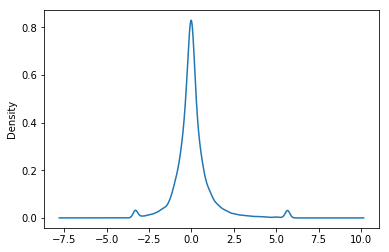

In [155]:
final_21opt_data.RelativeOptimism.plot.density()

In [156]:
# expression=build_R_style_expression('RelativeOptimism',['AnaAttention', 'ReportAttention',
#        'roe', 'growth', 'EPS',
#        'RelativeAnaExperience', 'RelativeCoNumber',
#        'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
#        'CompanyOpacity'],['Big4', 'LOSS'])
expression=build_R_style_expression('RelativeOptimism',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       ],['Big4', 'LOSS','CompanyOpacity'])

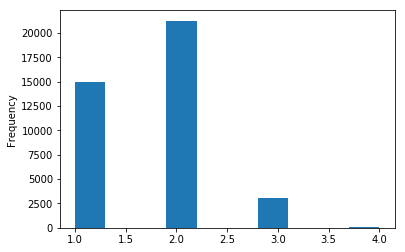

In [157]:
final_21opt_data['CompanyOpacity'].plot.hist()

In [158]:
model_21_opt=smf.api.ols(expression,data=final_21opt_data).fit()
model_21_opt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeOptimism   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.934
Date:                Fri, 02 Mar 2018   Prob (F-statistic):           2.38e-15
Time:                        15:51:50   Log-Likelihood:                -60018.
No. Observations:               39400   AIC:                         1.201e+05
Df Residuals:                   39384   BIC:                         1.202e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1662      0.023      7.150      0.000       0.121       0.212
C(Big4)[T.1.0]              -0.0064      0.016     -0.403      0.687      -0.038       0.025
C(LOSS)[T.1.0]               0.0096      0.016      0.615      0.538      -0.021       0.040
C(CompanyOpacity)[T.2.0]    -0.0209      0.013     -1.647      0.099      -0.046       0.004
C(CompanyOpacity)[T.3.0]     0.0491      0.022      2.190      0.029       0.005       0.093
C(CompanyOpacity)[T.4.0]     0.0530      0.105      0.503      0.615      -0.153       0.259
AnaAttention                -0.0048      0.001     -4.359      0.000      -0.007      -0.003
ReportAttention              0.0005      0.000      1.217      0.224      -0.000       0.001
roe                         -0.0548      0.058     -0.952      0.341      -0.168       0.058
growth                       0.0168      0.015      1.116      0.265      -0.013       0.046
EPS                          0.0066      0.015      0.435      0.664      -0.023       0.036
RelativeAnaExperience       -0.0072      0.002     -3.788      0.000      -0.011      -0.003
RelativeCoNumber             0.0007      0.001      1.362      0.173      -0.000       0.002
RelativeNumber               0.0003      0.000      1.857      0.063   -1.39e-05       0.001
AnalystExperience            0.0033      0.002      2.102      0.036       0.000       0.006
FollowCoNumber              -0.0014      0.000     -3.441      0.001      -0.002      -0.001
==============================================================================
Omnibus:                    14492.375   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118846.880
Skew:                           1.547   Prob(JB):                         0.00
Kurtosis:                      10.926   Cond. No.                     1.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [561]:
model_21_opt.pvalues[model_21_opt.pvalues>0.05].keys()

Index(['C(Big4)[T.1.0]', 'C(LOSS)[T.1.0]', 'ReportAttention', 'roe', 'growth',
       'EPS', 'RelativeCoNumber', 'RelativeNumber', 'CompanyOpacity'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a3f58dc88>,
      dtype=object)

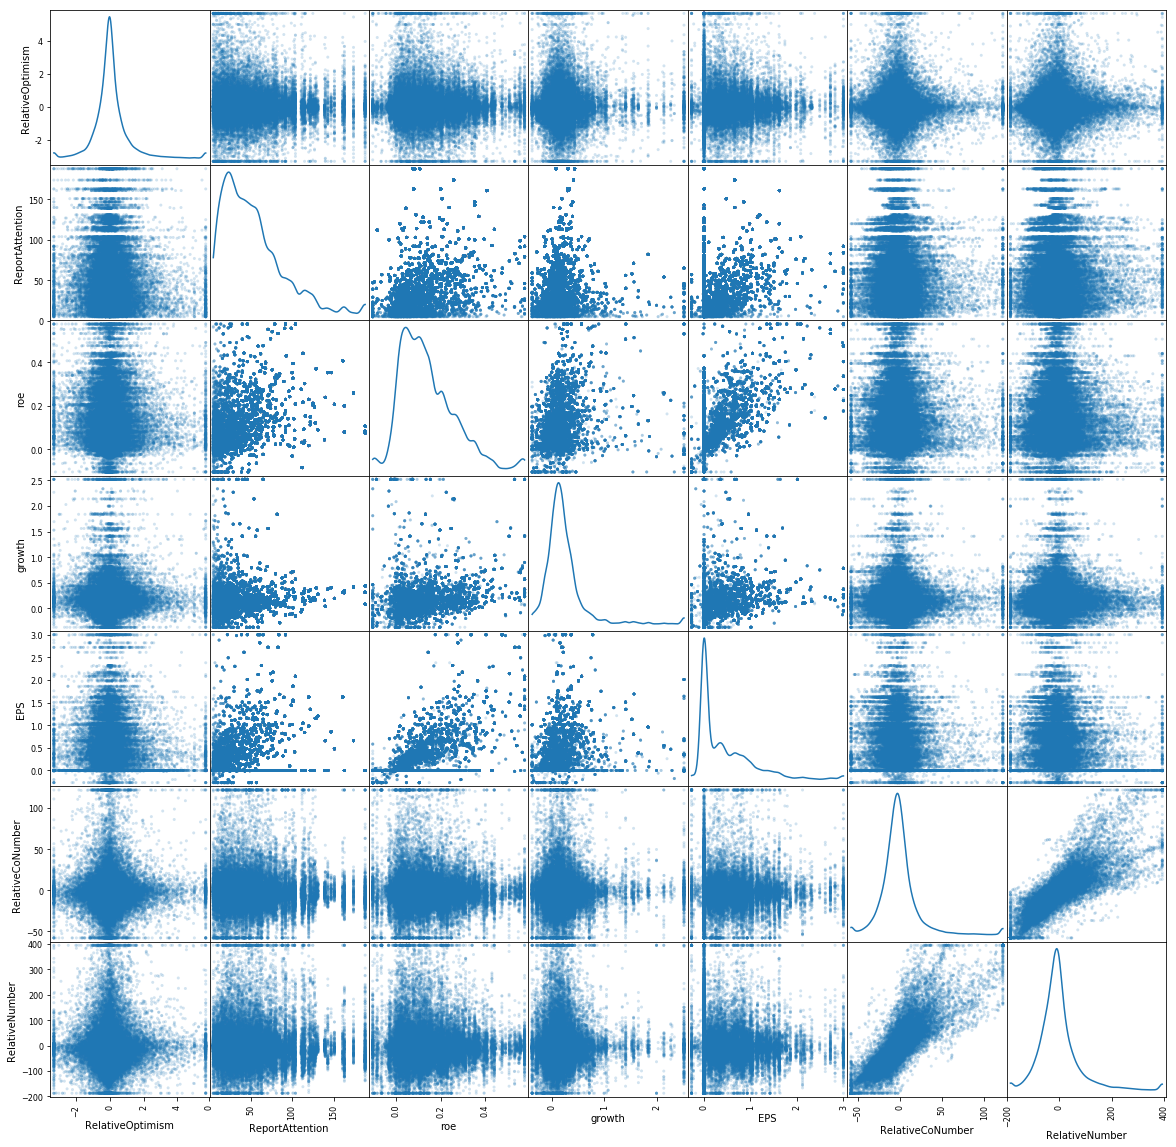

In [549]:
# model_21_opt.pvalues[model_21_opt.pvalues>0.05].keys()
from pandas.plotting import scatter_matrix
scatter_matrix(final_21opt_data[['RelativeOptimism','ReportAttention', 'roe', 'growth',
       'EPS', 'RelativeCoNumber', 'RelativeNumber']], alpha=0.2, figsize=(20, 20), diagonal='kde')

---

###  2-1 RelativeRecommendation

In [159]:
expression=build_R_style_expression('RelativeRecommendation',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'CompanyOpacity'],['Big4', 'LOSS'])

In [160]:
smf.api.ols(expression,data=final_21rec_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     RelativeRecommendation   R-squared:                       0.015
Model:                                OLS   Adj. R-squared:                  0.015
Method:                     Least Squares   F-statistic:                     49.60
Date:                    Fri, 02 Mar 2018   Prob (F-statistic):          2.28e-128
Time:                            15:52:06   Log-Likelihood:                -36559.
No. Observations:                   42301   AIC:                         7.315e+04
Df Residuals:                       42287   BIC:                         7.327e+04
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0188      0.014      1.357      0.175      -0.008       0.046
C(Big4)[T.1.0]            0.0327      0.008      4.142      0.000       0.017       0.048
C(LOSS)[T.1.0]            0.0234      0.008      3.021      0.003       0.008       0.039
AnaAttention              0.0065      0.001     11.602      0.000       0.005       0.008
ReportAttention          -0.0034      0.000    -17.970      0.000      -0.004      -0.003
roe                       0.1495      0.028      5.359      0.000       0.095       0.204
growth                   -0.0178      0.007     -2.495      0.013      -0.032      -0.004
EPS                      -0.0324      0.008     -4.278      0.000      -0.047      -0.018
RelativeAnaExperience    -0.0009      0.001     -0.888      0.375      -0.003       0.001
RelativeCoNumber         -0.0015      0.000     -5.566      0.000      -0.002      -0.001
RelativeNumber            0.0005   6.88e-05      7.070      0.000       0.000       0.001
AnalystExperience        -0.0006      0.001     -0.821      0.412      -0.002       0.001
FollowCoNumber           -0.0007      0.000     -3.478      0.001      -0.001      -0.000
CompanyOpacity            0.0072      0.005      1.515      0.130      -0.002       0.017
==============================================================================
Omnibus:                     1951.774   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4349.446
Skew:                          -0.301   Prob(JB):                         0.00
Kurtosis:                       4.451   Cond. No.                         859.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
expression=build_R_style_expression('C(RelativeRecommendation)',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'CompanyOpacity'],['Big4', 'LOSS'])

#### 此处我们试试用 multinomial logistic regression
- 还没确定是否使用

In [179]:
smf.api.mnlogit(expression,data=final_21rec_data).fit().summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/discrete/discrete_model.py:1673: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/usr/local/lib/python3.5/dist-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
/usr/local/lib/python3.5/dist-packages/statsmodels/base/optimizer.py:230: RuntimeWarning: invalid value encountered in greater
  oldparams) > tol)):


Optimization terminated successfully.
         Current function value: nan
         Iterations 4


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

---
### 2-2 ForecastOptimism

In [162]:
# ['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
#        'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
#        'AnaAttention', 'CompanySize',
#        'LOSS', 'Big4', 'EPS',
#        'roe','growth','ForecastOptimism']
expression=build_R_style_expression('ForecastOptimism',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'CompanyOpacity','StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'underwriter','SecSize','Big4', 'LOSS'])

In [163]:
smf.api.ols(expression,data=final_22optbias_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ForecastOptimism   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     200.8
Date:                Fri, 02 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:52:15   Log-Likelihood:                 44919.
No. Observations:               20710   AIC:                        -8.981e+04
Df Residuals:                   20695   BIC:                        -8.969e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1492      0.004    -34.474      0.000      -0.158      -0.141
C(underwriter)[T.1.0]    -0.0009      0.000     -2.068      0.039      -0.002   -4.95e-05
C(SecSize)[T.1.0]         0.0021      0.000      4.151      0.000       0.001       0.003
C(Big4)[T.1.0]           -0.0034      0.001     -5.919      0.000      -0.005      -0.002
C(LOSS)[T.1.0]            0.0020      0.001      3.662      0.000       0.001       0.003
AnaAttention             -0.0001   3.96e-05     -3.087      0.002      -0.000   -4.46e-05
ReportAttention        -4.51e-05   1.48e-05     -3.049      0.002   -7.41e-05   -1.61e-05
roe                      -0.0259      0.002    -13.647      0.000      -0.030      -0.022
growth                   -0.0013      0.000     -4.168      0.000      -0.002      -0.001
EPS                      -0.0004      0.001     -0.746      0.455      -0.001       0.001
CompanyOpacity            0.0053      0.000     15.712      0.000       0.005       0.006
StarAnalyst               0.0002   1.72e-05     10.425      0.000       0.000       0.000
ActiveAnalyst          4.472e-05   1.44e-05      3.106      0.002    1.65e-05    7.29e-05
ReportNumber          -7.012e-06      4e-07    -17.510      0.000    -7.8e-06   -6.23e-06
np.log(CompanySize)       0.0073      0.000     39.774      0.000       0.007       0.008
==============================================================================
Omnibus:                     4376.690   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12433.580
Skew:                           1.116   Prob(JB):                         0.00
Kurtosis:                       6.071   Cond. No.                     2.92e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2-2 RelativeOptimism

In [164]:
# ['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
#        'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
#        'AnaAttention', 'CompanySize',
#        'LOSS', 'Big4', 'EPS',
#        'roe','growth','ForecastOptimism']
expression=build_R_style_expression('RelativeOptimism',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'CompanyOpacity','StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'underwriter','SecSize','Big4', 'LOSS'])

In [165]:
smf.api.ols(expression,data=final_22opt_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeOptimism   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.492
Date:                Fri, 02 Mar 2018   Prob (F-statistic):           3.75e-08
Time:                        15:52:19   Log-Likelihood:                -30403.
No. Observations:               19260   AIC:                         6.084e+04
Df Residuals:                   19245   BIC:                         6.095e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2645      0.189      1.402      0.161      -0.105       0.634
C(underwriter)[T.1.0]     0.0206      0.020      1.013      0.311      -0.019       0.060
C(SecSize)[T.1.0]         0.0807      0.022      3.682      0.000       0.038       0.124
C(Big4)[T.1.0]           -0.0008      0.025     -0.030      0.976      -0.049       0.048
C(LOSS)[T.1.0]           -0.0236      0.024     -0.972      0.331      -0.071       0.024
AnaAttention             -0.0009      0.002     -0.512      0.608      -0.004       0.002
ReportAttention          -0.0007      0.001     -1.094      0.274      -0.002       0.001
roe                      -0.2332      0.084     -2.766      0.006      -0.398      -0.068
growth                    0.0294      0.013      2.312      0.021       0.004       0.054
EPS                       0.0178      0.023      0.780      0.435      -0.027       0.063
CompanyOpacity           -0.0223      0.015     -1.481      0.139      -0.052       0.007
StarAnalyst              -0.0003      0.001     -0.444      0.657      -0.002       0.001
ActiveAnalyst             0.0010      0.001      1.695      0.090      -0.000       0.002
ReportNumber          -6.051e-05   1.68e-05     -3.597      0.000   -9.35e-05   -2.75e-05
np.log(CompanySize)      -0.0047      0.008     -0.586      0.558      -0.020       0.011
==============================================================================
Omnibus:                     6875.582   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58943.760
Skew:                           1.476   Prob(JB):                         0.00
Kurtosis:                      11.046   Cond. No.                     3.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###  2-2 RelativeRecommendation

In [166]:
# ['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
#        'SecLoct', 'underwriter', 'CompanyOpacity', 'ReportAttention',
#        'AnaAttention', 'CompanySize',
#        'LOSS', 'Big4', 'EPS',
#        'roe','growth','ForecastOptimism']
expression=build_R_style_expression('RelativeRecommendation',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'CompanyOpacity','StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'underwriter','SecSize','Big4', 'LOSS'])

In [167]:
smf.api.ols(expression,data=final_22rec_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     RelativeRecommendation   R-squared:                       0.030
Model:                                OLS   Adj. R-squared:                  0.030
Method:                     Least Squares   F-statistic:                     46.63
Date:                    Fri, 02 Mar 2018   Prob (F-statistic):          3.68e-128
Time:                            15:52:23   Log-Likelihood:                -17507.
No. Observations:                   20826   AIC:                         3.504e+04
Df Residuals:                       20811   BIC:                         3.516e+04
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1625      0.088      1.856      0.064      -0.009       0.334
C(underwriter)[T.1.0]     0.0394      0.009      4.217      0.000       0.021       0.058
C(SecSize)[T.1.0]         0.1566      0.010     15.621      0.000       0.137       0.176
C(Big4)[T.1.0]            0.0222      0.011      1.959      0.050   -8.25e-06       0.044
C(LOSS)[T.1.0]            0.0130      0.011      1.169      0.242      -0.009       0.035
AnaAttention              0.0072      0.001      9.081      0.000       0.006       0.009
ReportAttention          -0.0032      0.000    -11.241      0.000      -0.004      -0.003
roe                      -0.0127      0.038     -0.333      0.739      -0.087       0.062
growth                   -0.0086      0.006     -1.491      0.136      -0.020       0.003
EPS                       0.0168      0.011      1.589      0.112      -0.004       0.038
CompanyOpacity           -0.0006      0.007     -0.081      0.936      -0.014       0.013
StarAnalyst               0.0033      0.000      9.444      0.000       0.003       0.004
ActiveAnalyst            -0.0025      0.000     -9.007      0.000      -0.003      -0.002
ReportNumber          -6.846e-05   7.74e-06     -8.840      0.000   -8.36e-05   -5.33e-05
np.log(CompanySize)      -0.0069      0.004     -1.881      0.060      -0.014       0.000
==============================================================================
Omnibus:                      922.120   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2280.950
Skew:                          -0.250   Prob(JB):                         0.00
Kurtosis:                       4.542   Cond. No.                     3.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2 分组检验

In [168]:
def annotate_star(pvalue):
    if pvalue>0.1:
        return '{:,.3f}'.format((pvalue))
    if 0.05< pvalue<=0.1:
        return '{:,.3f}'.format((pvalue))+'*'
    if 0.01< pvalue<=0.05:
        return '{:,.3f}'.format((pvalue))+'**'
    if pvalue <=0.01:
        return '{:,.3f}'.format((pvalue))+'***'

In [169]:
# model 2-1 optimism-bias
model2_1optbias_expression=build_R_style_expression('ForecastOptimism',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'CompanyOpacity'],['Big4', 'LOSS'])
shareholder0=final_21optbias_data[final_21optbias_data.FundShareholder==0]
shareholder1=final_21optbias_data[final_21optbias_data.FundShareholder==1]
starAnalyst0=final_21optbias_data[final_21optbias_data.IsStarAnalyst==0]
starAnalyst1=final_21optbias_data[final_21optbias_data.IsStarAnalyst==1]
group_test_result=[]
for g in [final_21optbias_data,shareholder0,shareholder1,starAnalyst0,starAnalyst1]:
    group_test_result.append(smf.api.ols(model2_1optbias_expression,data=g).fit().pvalues)
group_test_result=pd.DataFrame(group_test_result).T
group_test_result.columns=['Original','fundShareHolder_0','fundShareHolder_1','isStarAnalyst_0','isStarAnalyst_1']
# group_test_result.applymap(('{:,.8f}'.format))
group_test_result.applymap(annotate_star)

Original fundShareHolder_0 fundShareHolder_1  \
Intercept              0.000***          0.000***          0.000***   
C(Big4)[T.1.0]            0.616          0.009***             0.773   
C(LOSS)[T.1.0]            0.731             0.582            0.088*   
AnaAttention           0.000***          0.000***           0.017**   
ReportAttention        0.000***          0.000***             0.146   
roe                    0.000***          0.000***          0.000***   
growth                 0.000***          0.000***          0.000***   
EPS                    0.000***          0.000***          0.000***   
RelativeAnaExperience  0.001***            0.076*          0.001***   
RelativeCoNumber       0.000***          0.000***          0.000***   
RelativeNumber           0.074*             0.131          0.002***   
AnalystExperience      0.000***          0.001***          0.005***   
FollowCoNumber         0.000***             0.658          0.000***   
CompanyOpacity         0.000***          0.000***          0.000***   

                      isStarAnalyst_0 isStarAnalyst_1  
Intercept                    0.000***        0.000***  
C(Big4)[T.1.0]                  0.208           0.300  
C(LOSS)[T.1.0]                  0.672         0.042**  
AnaAttention                 0.001***         0.015**  
ReportAttention              0.000***        0.005***  
roe                          0.000***        0.000***  
growth                       0.000***        0.000***  
EPS                          0.000***        0.000***  
RelativeAnaExperience        0.001***           0.973  
RelativeCoNumber             0.000***           0.906  
RelativeNumber               0.010***         0.015**  
AnalystExperience            0.000***           0.889  
FollowCoNumber                 0.052*        0.000***  
CompanyOpacity               0.000***        0.000***

In [171]:
# model 2-1 recommendation
model2_1rec_expression=build_R_style_expression('RelativeRecommendation',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'CompanyOpacity'],['Big4', 'LOSS'])
shareholder0=final_21rec_data[final_21rec_data.FundShareholder==0]
shareholder1=final_21rec_data[final_21rec_data.FundShareholder==1]
starAnalyst0=final_21rec_data[final_21rec_data.IsStarAnalyst==0]
starAnalyst1=final_21rec_data[final_21rec_data.IsStarAnalyst==1]
group_test_result=[]
for g in [final_21rec_data,shareholder0,shareholder1,starAnalyst0,starAnalyst1]:
    group_test_result.append(smf.api.ols(model2_1rec_expression,data=g).fit().pvalues)
group_test_result=pd.DataFrame(group_test_result).T
group_test_result.columns=['Original','fundShareHolder_0','fundShareHolder_1','isStarAnalyst_0','isStarAnalyst_1']
group_test_result.applymap(annotate_star)

Original fundShareHolder_0 fundShareHolder_1  \
Intercept                 0.175            0.099*          0.000***   
C(Big4)[T.1.0]         0.000***           0.028**           0.014**   
C(LOSS)[T.1.0]         0.003***           0.012**            0.055*   
AnaAttention           0.000***          0.000***          0.000***   
ReportAttention        0.000***          0.000***          0.000***   
roe                    0.000***             0.212          0.000***   
growth                  0.013**             0.561             0.699   
EPS                    0.000***             0.429          0.001***   
RelativeAnaExperience     0.375             0.516            0.060*   
RelativeCoNumber       0.000***             0.890          0.000***   
RelativeNumber         0.000***          0.006***          0.000***   
AnalystExperience         0.412             0.331           0.011**   
FollowCoNumber         0.001***             0.254          0.002***   
CompanyOpacity            0.130           0.015**            0.051*   

                      isStarAnalyst_0 isStarAnalyst_1  
Intercept                       0.454        0.000***  
C(Big4)[T.1.0]               0.000***           0.486  
C(LOSS)[T.1.0]               0.001***           0.391  
AnaAttention                 0.000***        0.000***  
ReportAttention              0.000***        0.000***  
roe                          0.000***        0.000***  
growth                          0.378        0.000***  
EPS                          0.000***         0.027**  
RelativeAnaExperience           0.341           0.247  
RelativeCoNumber             0.000***           0.169  
RelativeNumber               0.000***           0.578  
AnalystExperience               0.826          0.084*  
FollowCoNumber                 0.058*        0.001***  
CompanyOpacity                0.013**           0.110

In [172]:
# model 2-2 optimism-bias
model2_2optbias_expression=build_R_style_expression('ForecastOptimism',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'CompanyOpacity','StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'underwriter','SecSize','Big4', 'LOSS'])
shareholder0=final_22optbias_data[final_22optbias_data.FundShareholder==0]
shareholder1=final_22optbias_data[final_22optbias_data.FundShareholder==1]
starAnalyst0=final_22optbias_data[final_22optbias_data.IsStarAnalyst==0]
starAnalyst1=final_22optbias_data[final_22optbias_data.IsStarAnalyst==1]
group_test_result=[]
for g in [final_22optbias_data,shareholder0,shareholder1,starAnalyst0,starAnalyst1]:
    group_test_result.append(smf.api.ols(model2_2optbias_expression,data=g).fit().pvalues)
group_test_result=pd.DataFrame(group_test_result).T
group_test_result.columns=['Original','fundShareHolder_0','fundShareHolder_1','isStarAnalyst_0','isStarAnalyst_1']
group_test_result.applymap(annotate_star)

Original fundShareHolder_0 fundShareHolder_1  \
Intercept              0.000***          0.000***          0.000***   
C(underwriter)[T.1.0]   0.039**             0.349             0.552   
C(SecSize)[T.1.0]      0.000***           0.027**          0.000***   
C(Big4)[T.1.0]         0.000***             0.227          0.000***   
C(LOSS)[T.1.0]         0.000***           0.046**          0.000***   
AnaAttention           0.002***             0.992          0.001***   
ReportAttention        0.002***           0.013**             0.104   
roe                    0.000***          0.000***          0.000***   
growth                 0.000***             0.840          0.000***   
EPS                       0.455             0.891             0.388   
CompanyOpacity         0.000***          0.000***          0.000***   
StarAnalyst            0.000***          0.000***          0.000***   
ActiveAnalyst          0.002***          0.000***          0.000***   
ReportNumber           0.000***          0.000***           0.016**   
np.log(CompanySize)    0.000***          0.000***          0.000***   

                      isStarAnalyst_0 isStarAnalyst_1  
Intercept                    0.000***        0.000***  
C(underwriter)[T.1.0]         0.011**           0.415  
C(SecSize)[T.1.0]            0.000***           0.201  
C(Big4)[T.1.0]               0.000***        0.000***  
C(LOSS)[T.1.0]               0.001***          0.089*  
AnaAttention                 0.000***         0.037**  
ReportAttention                 0.128        0.000***  
roe                          0.000***          0.076*  
growth                       0.000***           0.491  
EPS                             0.989          0.053*  
CompanyOpacity               0.000***        0.000***  
StarAnalyst                  0.000***        0.004***  
ActiveAnalyst                0.001***           0.835  
ReportNumber                 0.000***        0.000***  
np.log(CompanySize)          0.000***        0.000***

In [173]:
# model 2-2 recommendation
model2_2rec_expression=build_R_style_expression('RelativeRecommendation',['AnaAttention', 'ReportAttention',
       'roe', 'growth', 'EPS',
       'CompanyOpacity','StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'underwriter','SecSize','Big4', 'LOSS'])
shareholder0=final_22rec_data[final_22rec_data.FundShareholder==0]
shareholder1=final_22rec_data[final_22rec_data.FundShareholder==1]
starAnalyst0=final_22rec_data[final_22rec_data.IsStarAnalyst==0]
starAnalyst1=final_22rec_data[final_22rec_data.IsStarAnalyst==1]
group_test_result=[]
for g in [final_22rec_data,shareholder0,shareholder1,starAnalyst0,starAnalyst1]:
    group_test_result.append(smf.api.ols(model2_2rec_expression,data=g).fit().pvalues)
group_test_result=pd.DataFrame(group_test_result).T
group_test_result.columns=['Original','fundShareHolder_0','fundShareHolder_1','isStarAnalyst_0','isStarAnalyst_1']
group_test_result.applymap(annotate_star)

Original fundShareHolder_0 fundShareHolder_1  \
Intercept                0.064*             0.417             0.192   
C(underwriter)[T.1.0]  0.000***          0.000***            0.077*   
C(SecSize)[T.1.0]      0.000***          0.000***          0.000***   
C(Big4)[T.1.0]           0.050*            0.088*             0.425   
C(LOSS)[T.1.0]            0.242             0.121             0.862   
AnaAttention           0.000***          0.004***          0.000***   
ReportAttention        0.000***          0.000***          0.000***   
roe                       0.739           0.012**           0.011**   
growth                    0.136             0.652             0.910   
EPS                       0.112             0.190             0.845   
CompanyOpacity            0.936             0.634             0.386   
StarAnalyst            0.000***          0.000***          0.000***   
ActiveAnalyst          0.000***             0.172             0.103   
ReportNumber           0.000***          0.000***          0.000***   
np.log(CompanySize)      0.060*            0.092*           0.047**   

                      isStarAnalyst_0 isStarAnalyst_1  
Intercept                     0.020**           0.744  
C(underwriter)[T.1.0]        0.000***         0.011**  
C(SecSize)[T.1.0]            0.000***           0.708  
C(Big4)[T.1.0]                0.023**           0.510  
C(LOSS)[T.1.0]                  0.747        0.009***  
AnaAttention                 0.000***        0.000***  
ReportAttention              0.000***        0.000***  
roe                            0.061*        0.000***  
growth                          0.426         0.012**  
EPS                             0.204           0.773  
CompanyOpacity                  0.871           0.864  
StarAnalyst                  0.000***        0.000***  
ActiveAnalyst                0.000***        0.000***  
ReportNumber                 0.000***        0.004***  
np.log(CompanySize)           0.018**           0.271

---
# Model 3
- 2018-02-25 14:01 PM
- 处理数据，构造矩阵

In [406]:
final_3optbias_data=model22_data[['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'CompanySize','AnaAttention',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','ForecastOptimism']]

In [407]:
final_3optbias_data=final_3optbias_data.dropna()

In [408]:
final_3optbias_data.shape

(21911, 12)

In [587]:
final_3opt_data=model22_data[['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'CompanySize','AnaAttention',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','RelativeOptimism']]

In [589]:
final_3opt_data=final_3opt_data.dropna()

In [590]:
final_3opt_data.shape

(20453, 12)

In [591]:
final_3opt_data=final_3opt_data.apply(lambda x: x.astype(np.float64),axis=1)
final_3optbias_data=final_3optbias_data.apply(lambda x: x.astype(np.float64),axis=1)

In [592]:
model3_numerical_variables=['SecSize', 'StarAnalyst', 'ActiveAnalyst', 'ReportNumber',
       'CompanySize','AnaAttention',
       'LOSS', 'Big4', 'EPS',
       'roe','growth','RelativeRecommendation','ForecastOptimism']
model3_data_list=[final_3opt_data,final_3optbias_data]
for nv in model3_numerical_variables:
    for md in model3_data_list:
        if nv in md.columns:
            lower=md[nv].quantile(q=0.01)
            upper=md[nv].quantile(q=0.99)
            md[nv][md[nv]<lower]=lower
            md[nv][md[nv]>upper]=upper

In [413]:
# model3 data processed done.
# 2018-02-12 22:52 PM

# Model 3 建模部分 

In [593]:
expression=build_R_style_expression('ForecastOptimism',['AnaAttention',
       'roe', 'growth', 'EPS',
       'StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'SecSize','Big4', 'LOSS'])
smf.api.ols(expression,data=final_3optbias_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ForecastOptimism   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     230.3
Date:                Mon, 26 Feb 2018   Prob (F-statistic):               0.00
Time:                        06:56:05   Log-Likelihood:                 47798.
No. Observations:               21911   AIC:                        -9.557e+04
Df Residuals:                   21899   BIC:                        -9.548e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1183      0.004    -31.387      0.000      -0.126      -0.111
C(SecSize)[T.1.0]       0.0019      0.000      3.908      0.000       0.001       0.003
C(Big4)[T.1.0]         -0.0045      0.001     -8.311      0.000      -0.006      -0.003
C(LOSS)[T.1.0]          0.0031      0.001      6.088      0.000       0.002       0.004
AnaAttention           -0.0003    1.8e-05    -15.839      0.000      -0.000      -0.000
roe                    -0.0258      0.002    -13.983      0.000      -0.029      -0.022
growth                 -0.0014      0.000     -4.285      0.000      -0.002      -0.001
EPS                    -0.0002      0.001     -0.296      0.767      -0.001       0.001
StarAnalyst             0.0002   1.64e-05     11.024      0.000       0.000       0.000
ActiveAnalyst        4.545e-05   1.37e-05      3.313      0.001    1.86e-05    7.23e-05
ReportNumber        -6.928e-06   3.75e-07    -18.455      0.000   -7.66e-06   -6.19e-06
np.log(CompanySize)     0.0064      0.000     38.205      0.000       0.006       0.007
==============================================================================
Omnibus:                     4802.926   Durbin-Watson:                   0.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14017.388
Skew:                           1.146   Prob(JB):                         0.00
Kurtosis:                       6.177   Cond. No.                     2.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [596]:
expression=build_R_style_expression('RelativeOptimism',['AnaAttention',
       'roe', 'growth', 'EPS',
       'StarAnalyst', 'ActiveAnalyst', 'ReportNumber','np.log(CompanySize)'],[ 'SecSize','Big4', 'LOSS'])
smf.api.ols(expression,data=final_3opt_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeOptimism   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.680
Date:                Mon, 26 Feb 2018   Prob (F-statistic):           3.00e-05
Time:                        06:56:25   Log-Likelihood:                -56888.
No. Observations:               20453   AIC:                         1.138e+05
Df Residuals:                   20441   BIC:                         1.139e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.3903      0.553      2.513      0.012       0.306       2.475
C(SecSize)[T.1.0]       0.2662      0.071      3.768      0.000       0.128       0.405
C(Big4)[T.1.0]          0.1291      0.078      1.648      0.099      -0.024       0.283
C(LOSS)[T.1.0]         -0.0774      0.077     -1.011      0.312      -0.227       0.073
AnaAttention           -0.0037      0.003     -1.359      0.174      -0.009       0.002
roe                    -0.5730      0.276     -2.074      0.038      -1.114      -0.032
growth                  0.0196      0.043      0.457      0.648      -0.064       0.104
EPS                     0.0372      0.074      0.500      0.617      -0.109       0.183
StarAnalyst             0.0025      0.002      1.071      0.284      -0.002       0.007
ActiveAnalyst           0.0004      0.002      0.211      0.833      -0.003       0.004
ReportNumber           -0.0002   5.37e-05     -3.223      0.001      -0.000   -6.78e-05
np.log(CompanySize)    -0.0489      0.024     -2.017      0.044      -0.096      -0.001
==============================================================================
Omnibus:                    12841.274   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1447455879.786
Skew:                          -0.818   Prob(JB):                         0.00
Kurtosis:                    1306.255   Cond. No.                     2.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###  model 3 regression analysis

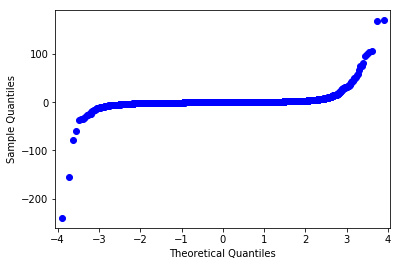

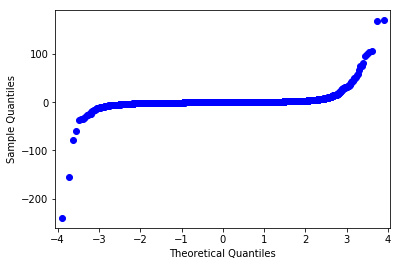

In [602]:
smd.qqplot(final_3opt_data['RelativeOptimism'])